In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

preprocessed_train_path = "C:\\Users\\fabio\\Downloads\\ETH\ML4H\Project\\Part 1\\preprocessed_heart_train_val.csv"
preprocessed_path = preprocessed_train_path.replace("\\" , "/")
df_train = pd.read_csv(preprocessed_path)

preprocessed_test_path = "C:\\Users\\fabio\\Downloads\\ETH\ML4H\Project\\Part 1\\preprocessed_heart_test.csv"
preprocessed_test_path = preprocessed_path.replace("\\" , "/")
df_test = pd.read_csv(preprocessed_test_path)

df_train

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Female,ChestPainType is _ATA,ChestPainType is _NAP,ChestPainType is _TA,RestingECG is _LVH,RestingECG is _ST,ST_Slope is _Down,ST_Slope is _Up
0,40.0,140.0,289.0,0.0,172.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,37.0,130.0,283.0,0.0,98.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,48.0,138.0,214.0,0.0,108.0,1.0,1.5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54.0,150.0,195.0,0.0,122.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,39.0,120.0,339.0,0.0,170.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41.0,120.0,157.0,0.0,182.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
730,57.0,140.0,241.0,0.0,123.0,1.0,0.2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
731,45.0,110.0,264.0,0.0,132.0,0.0,1.2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
732,68.0,144.0,193.0,1.0,141.0,0.0,3.4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


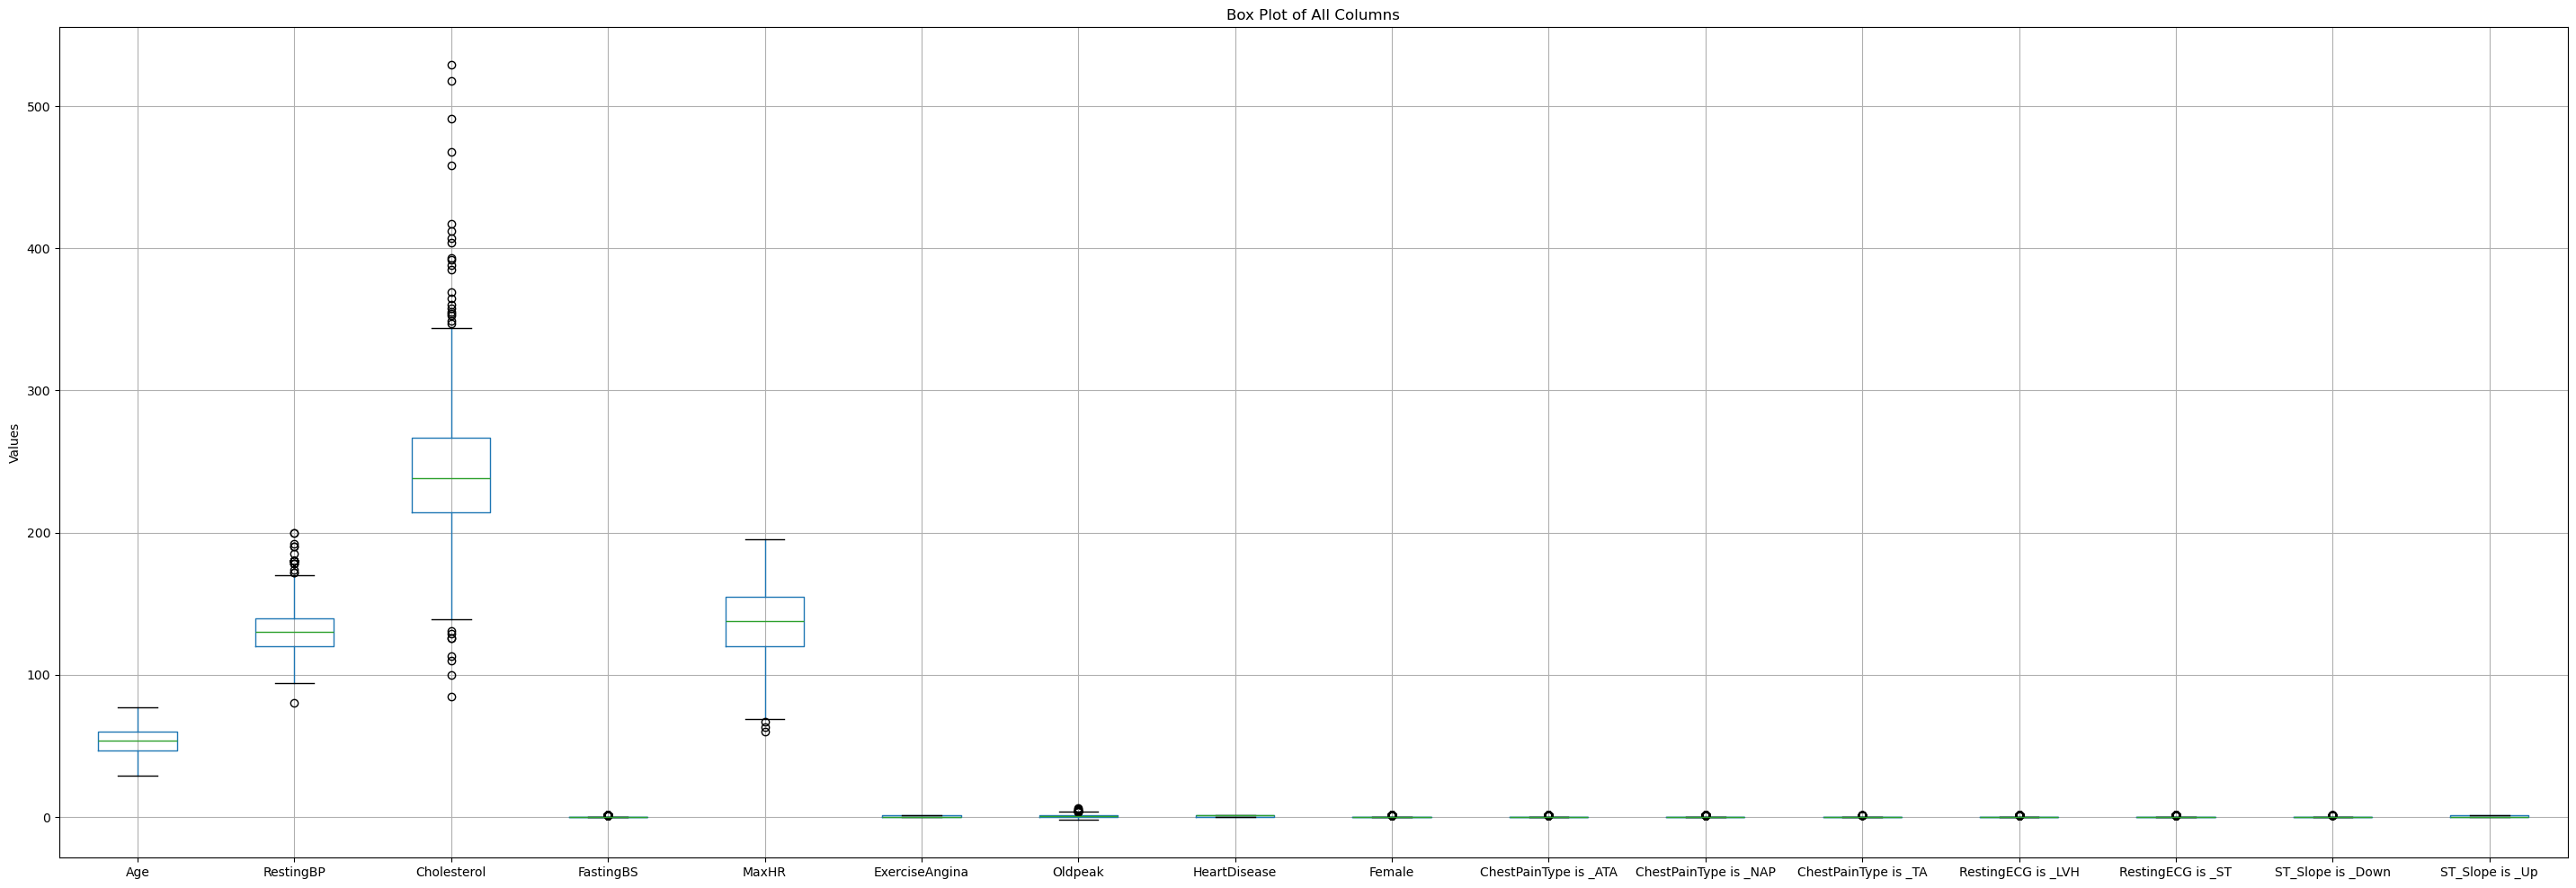

In [2]:
###Let's normalize data
##First, see if there are outliers

# Create a box plot of all columns
plt.figure(figsize=(36, 12))
df_train.boxplot()
plt.title('Box Plot of All Columns')
plt.ylabel('Values')
plt.grid(True)
plt.show()


In [5]:
#Separate features and target
X_train = df_train.drop(columns=['HeartDisease'])
X_test = df_test.drop(columns=['HeartDisease'])
y_train = df_train['HeartDisease']
y_test = df_test['HeartDisease']

#Since some vars are binary, to mantain consistency, lets apply minmax, not z-score
#And lets use normalization from train set
scaler = MinMaxScaler()
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [6]:
X_scaled_train.shape

(734, 15)

Let's do train/val split to find best alpha for Lasso

In [7]:
def negativeROCAUC(alpha,X_scaled_train,y_train):
        splits=10
        kf = KFold(n_splits=splits, shuffle=True, random_state=1)
        aucs = []

        for train_index, val_index in kf.split(X_scaled_train):
                # Split data into training and validation sets
                X_train_fold, X_val_fold = X_scaled_train[train_index], X_scaled_train[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
                
                # Fit Lasso regression model
                lasso = Lasso(alpha=alpha)
                lasso.fit(X_train_fold, y_train_fold)
                
                # Predict probabilities on validation set
                y_prob_val = lasso.predict(X_val_fold)
                
                # Calculate AUC-ROC score
                auc_roc = roc_auc_score(y_val_fold, y_prob_val)
                aucs.append(auc_roc)

        # Calculate average AUC-ROC score across folds
        return-np.mean(aucs)

In [8]:
negativeROCAUC(0.1,X_scaled_train,y_train)

-0.8137335387694404

I realized you get different local minima depending on the optimization boundary. I'm going forward with both, to see what gives more sparsity and what has higher roc auc.

In [22]:
from scipy.optimize import minimize_scalar

# Use scipy.optimize to find optimal alpha that minimizes ROCAUC function
result1 = minimize_scalar(negativeROCAUC, bounds=(0.0000001,0.1),args=(X_scaled_train, y_train))
result2 = minimize_scalar(negativeROCAUC, bounds=(0.001,0.1),args=(X_scaled_train, y_train))

# Get optimal alpha value
optimal_alpha1 = result1.x
optimal_alpha2 = result2.x

print("Optimal Alpha:", optimal_alpha1)

print(negativeROCAUC(result1.x,X_scaled_train,y_train))

print("Optimal Alpha:", optimal_alpha2)

print(negativeROCAUC(result2.x,X_scaled_train,y_train))


Optimal Alpha: 0.0007537829003194597
-0.9295700835983267
Optimal Alpha: 0.0023317274855250173
-0.9267932770918753


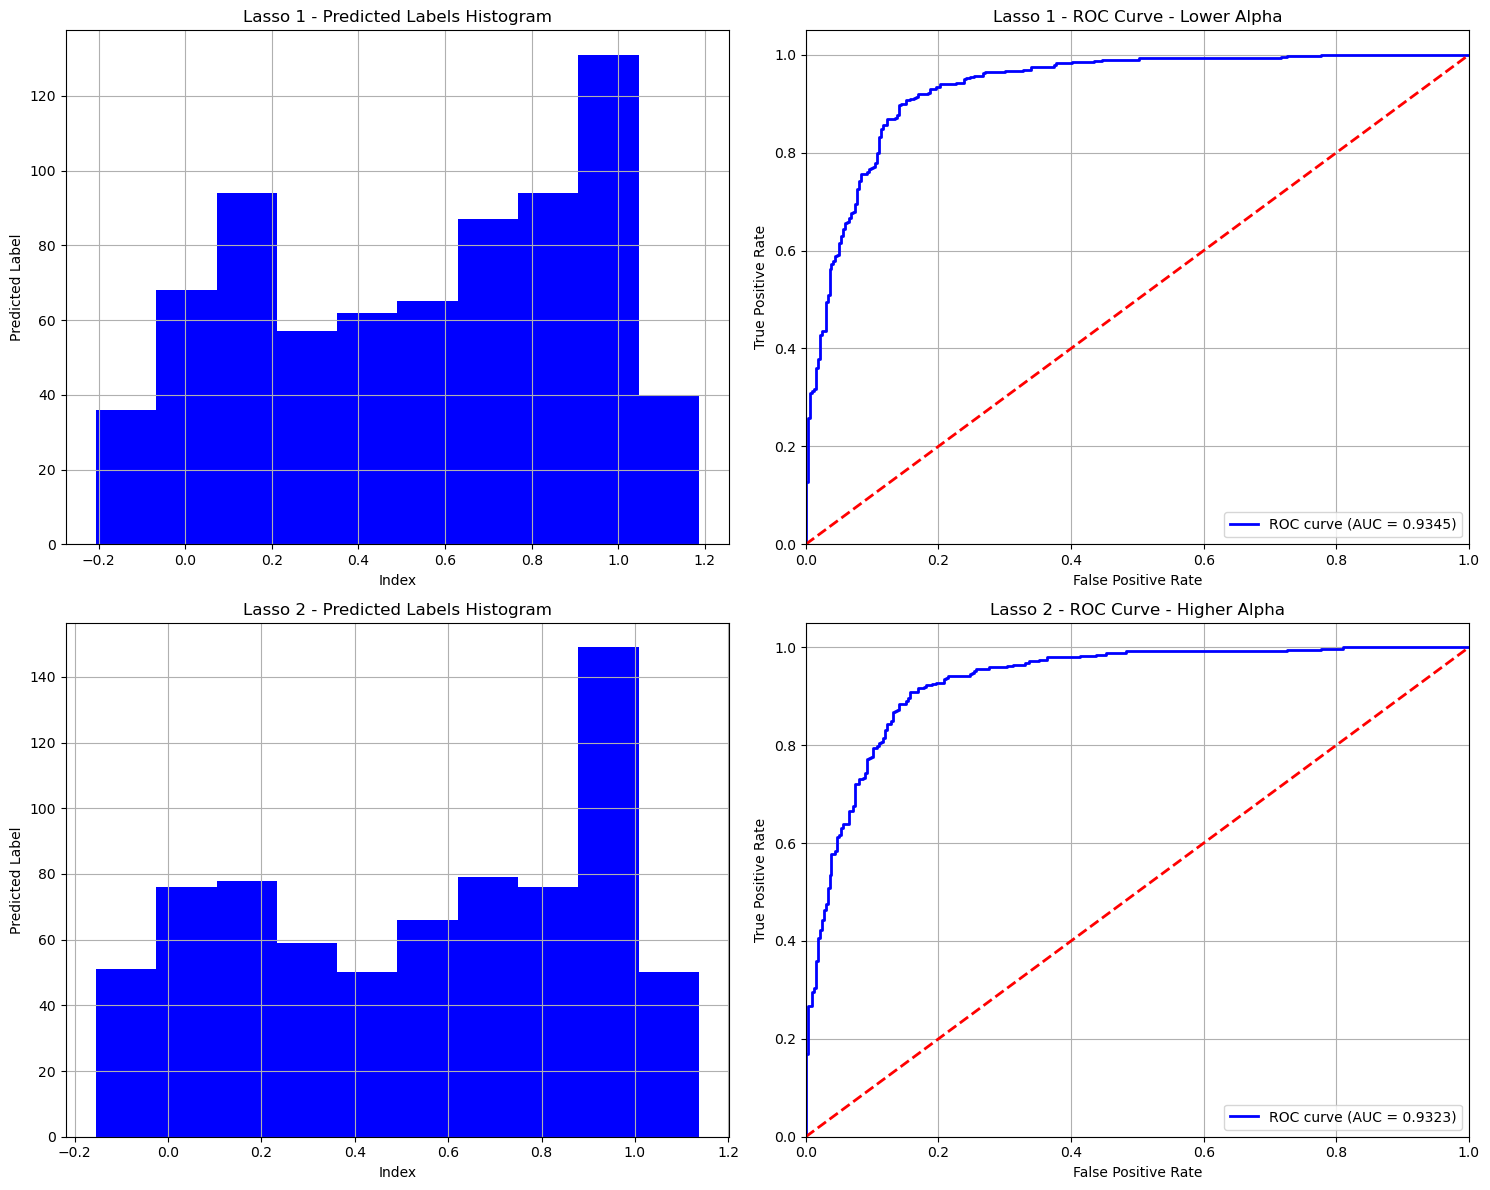

In [26]:
# Fit Lasso regression models with optimal alphas
lasso1 = Lasso(alpha=optimal_alpha1)
lasso1.fit(X_scaled_train, y_train)
y_pred1 = lasso1.predict(X_scaled_test)
auc1 = roc_auc_score(y_test, y_pred1)

lasso2 = Lasso(alpha=optimal_alpha2)
lasso2.fit(X_scaled_train, y_train)
y_pred2 = lasso2.predict(X_scaled_test)
auc2 = roc_auc_score(y_test, y_pred2)

# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot histograms and ROC curves for lasso1
axes[0, 0].hist(y_pred1, color='b')
axes[0, 0].set_title('Lasso 1 - Predicted Labels Histogram')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Predicted Label')
axes[0, 0].grid(True)

fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
axes[0, 1].plot(fpr1, tpr1, color='b', lw=2, label='ROC curve (AUC = %0.4f)' % auc1)
axes[0, 1].plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Lasso 1 - ROC Curve - Lower Alpha')
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(True)

# Plot histograms and ROC curves for lasso2
axes[1, 0].hist(y_pred2, color='b')
axes[1, 0].set_title('Lasso 2 - Predicted Labels Histogram')
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Predicted Label')
axes[1, 0].grid(True)

fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
axes[1, 1].plot(fpr2, tpr2, color='b', lw=2, label='ROC curve (AUC = %0.4f)' % auc2)
axes[1, 1].plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('Lasso 2 - ROC Curve - Higher Alpha')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [27]:
THRESHOLD=0.5

# Calculate balanced accuracy, F1 score, and confusion matrix for lasso1
y_pred_rounded1 = y_pred1 > THRESHOLD
balanced_acc1 = balanced_accuracy_score(y_test, y_pred_rounded1)
f1_1 = f1_score(y_test, y_pred_rounded1)
conf_matrix1 = confusion_matrix(y_test, y_pred_rounded1)

# Calculate balanced accuracy, F1 score, and confusion matrix for lasso2
y_pred_rounded2 = y_pred2 > THRESHOLD
balanced_acc2 = balanced_accuracy_score(y_test, y_pred_rounded2)
f1_2 = f1_score(y_test, y_pred_rounded2)
conf_matrix2 = confusion_matrix(y_test, y_pred_rounded2)

# Print metrics for lasso1
print("Lasso 1 Metrics:")
print("Balanced Accuracy:", balanced_acc1)
print("F1 Score:", f1_1)
print("Confusion Matrix:")
print(conf_matrix1)

# Print metrics for lasso2
print("\nLasso 2 Metrics:")
print("Balanced Accuracy:", balanced_acc2)
print("F1 Score:", f1_2)
print("Confusion Matrix:")
print(conf_matrix2)

Lasso 1 Metrics:
Balanced Accuracy: 0.8763684493898062
F1 Score: 0.8899876390605687
Confusion Matrix:
[[285  51]
 [ 38 360]]

Lasso 2 Metrics:
Balanced Accuracy: 0.8708796960995453
F1 Score: 0.88504326328801
Confusion Matrix:
[[283  53]
 [ 40 358]]


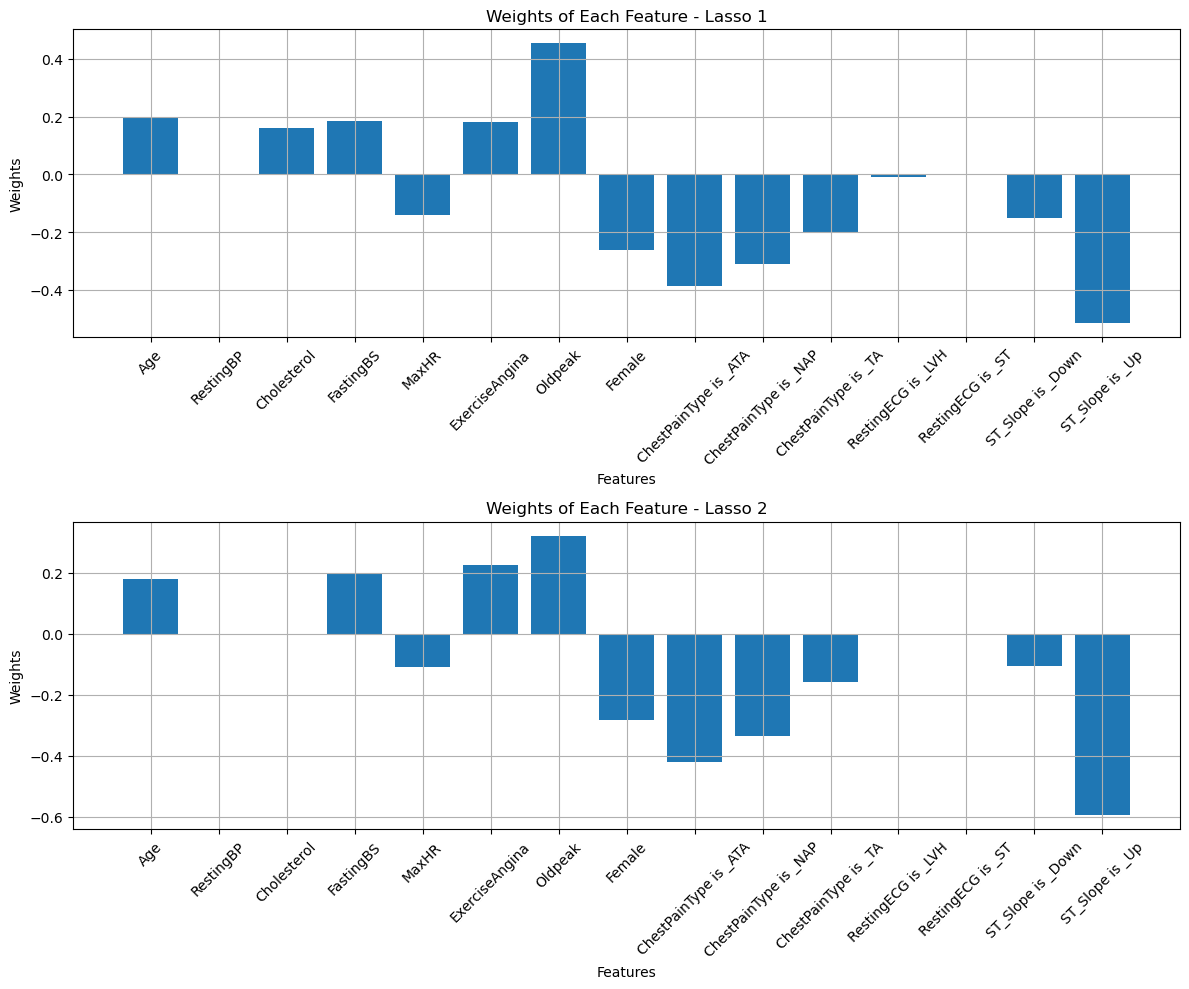

In [29]:
# Calculate normalized weights of each feature for lasso1
weights1 = lasso1.coef_ / np.linalg.norm(lasso1.coef_)

# Calculate normalized weights of each feature for lasso2
weights2 = lasso2.coef_ / np.linalg.norm(lasso2.coef_)

# Create subplots for both Lasso models
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot weights for lasso1
axes[0].bar(X_train.columns, weights1)
axes[0].set_title('Weights of Each Feature - Lasso 1')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Weights')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Plot weights for lasso2
axes[1].bar(X_train.columns, weights2)
axes[1].set_title('Weights of Each Feature - Lasso 2')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Weights')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()  